In [12]:
#import dependencies (5)
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper (5)
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [15]:
# create engine to hawaii.sqlite (5)
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
 # Declare a Base using `automap_base()` (5)
Base = automap_base()

# reflect an existing database into a new model (5)
Base.prepare(autoload_with=engine)

In [17]:
# View all of the classes that automap found (5)
Base.classes.keys()

['station', 'measurement']

In [18]:
# Save references to each table (5)
measurements = Base.classes.measurement

stations = Base.classes.measurement

In [19]:
#Inspect tables in database, to collect column metadata. (5)
#Create inspector and connecting it to the engine object
inspector = inspect(engine)

#Inspect columns in 'measurements' table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Inspect columns in 'station' table (5)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Precipitation Analysis

In [20]:
# Create our session (link) from Python to the DB (5)
session = Session(engine)

In [21]:
# Find the most recent date in the data set. (6)
most_recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()[0]
most_recent_date

'2017-08-23'

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. Convert str date to datetime object. (7)
latest_date = datetime.strptime(most_recent_date.replace("-","/"),"%Y/%m/%d")

# Calculate the date one year from the last date in data set. (8)
latest_date_minus_one_year = latest_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores (9)
data = session.query(measurements.date,measurements.prcp).filter(measurements.date >= latest_date_minus_one_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names, and drop any entires with NaN values.
prcp_df = pd.DataFrame(data, columns=['Date','Precipitation']).dropna()

# Sort the dataframe by date, store in new DataFrame for plotting.
sorted_prcp = prcp_df.sort_values(by = 'Date')

In [23]:
#create xtick lists using 155 as a factor for 2015 (count of date values in dataframe) for even x-axis lable spacing.
all_dates = (sorted_prcp.Date).to_list()
x_tick_values = [d for n, d in enumerate(all_dates) if n%155==0]
x_tick_location_values = [n for n, d in enumerate(all_dates) if n%155==0]

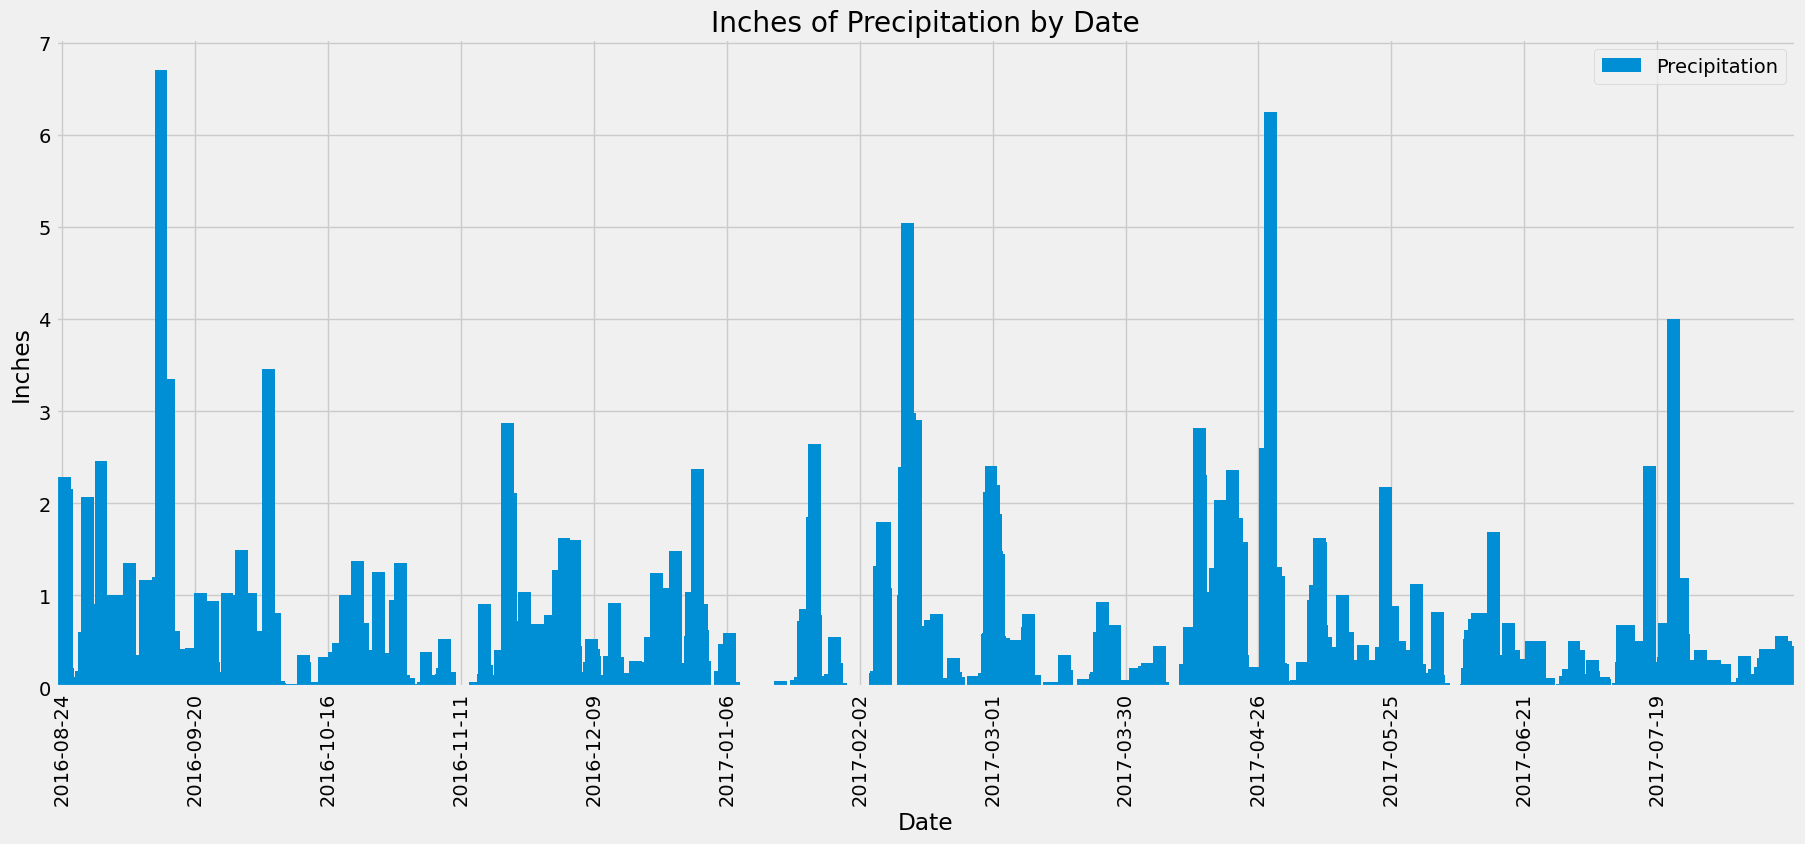

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data (10)
ax = sorted_prcp.plot.bar(x='Date',
                        y='Precipitation',
                        xlabel='Date',
                        ylabel='Inches',
                        title='Inches of Precipitation by Date',
                        rot=90,
                        width = 15,
                        figsize=(20,8)
                       )
plt.xticks(x_tick_location_values,x_tick_values)

plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data (11)
sorted_prcp.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Close Session
session.close()

# Station Analysis

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [29]:
# Design a query to calculate the total number of stations in the dataset (12)
unique_stations = session.query(stations.station).distinct().count()
unique_stations

9

In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?) (9)
station_count = session.query(stations.station,func.count(stations.station)).\
    group_by(stations.station).\
    order_by(func.count(stations.station).desc()).\
    all()

# List the stations and their counts in descending order.
for station in station_count:
    print(station)

#save ID number of most active station in variable for later use
most_active_station = station_count[0][0]

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. (5)
most_active_station_data = session.query(
    func.min(measurements.tobs),
    func.max(measurements.tobs),
    func.avg(measurements.tobs)
    ).\
    filter(measurements.station == most_active_station).\
    all()

print(f"Station #{station_count[0][0]} is the most active.")
print(f"Lowest recorded temperature at {most_active_station}: {most_active_station_data[0][0]}f")
print(f"Highest recorded temperature at {most_active_station}: {most_active_station_data[0][1]}f")
print(f"Average recorded temperature at {most_active_station}: {round(most_active_station_data[0][2],2)}f")

Station #USC00519281 is the most active.
Lowest recorded temperature at USC00519281: 54.0f
Highest recorded temperature at USC00519281: 85.0f
Average recorded temperature at USC00519281: 71.66f


In [40]:
# Using the most active station id, query the last 12 months of temperature observation data for the most active station.
#Same code used from Precipitation Analysis above to calculate date values to pass into query
most_recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()[0] #(6)
latest_date = datetime.strptime(most_recent_date.replace("-","/"),"%Y/%m/%d") #(7)
latest_date_minus_one_year = latest_date - timedelta(days=365) #(8)

tempData = session.query(measurements.tobs).\
    filter(measurements.date >= latest_date_minus_one_year).\
    filter(measurements.station == most_active_station).\
    all()

#extract temp values from tuples returned by query, to use in histogram.
newlist = [n[0] for n in tempData]

In [36]:
#convert list of TOBS records into DataFrame
tobs_df = pd.DataFrame(newlist,columns = ['TOBS'])

,TOBS
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


Text(0, 0.5, 'Frequency')

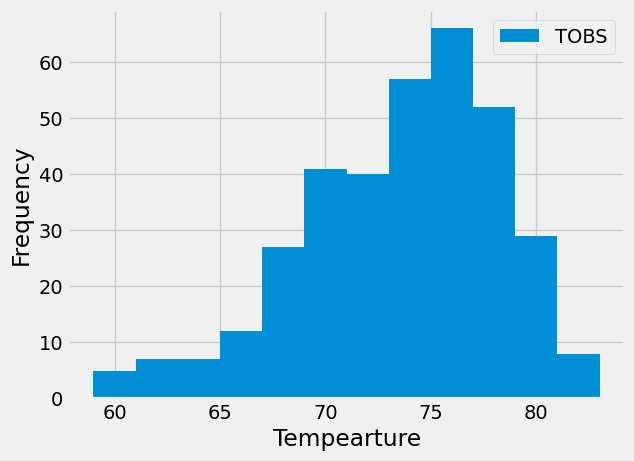

In [37]:
#create histogram from TOBS DataFrame (13)
tobs_df.plot.hist(bins=12,label='TOBS')
plt.xlabel('Tempearture')
plt.ylabel('Frequency')

In [41]:
# Close Session
session.close()